## Empathy Cues Graphs

In [75]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### Add the Who collumn to the BERT dataset

In [76]:
# Function to count pronouns in a text
def count_pronouns(text, pronouns):
    count = 0
    words = text.split()
    for word in words:
        if word.lower() in pronouns:
            count += 1
    return count

In [77]:


# pronoun groups
pronoun_groups = {0: ['I', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ourselfs'],
                1: ['you', 'your', 'yours', 'yourself', 'yourselves'],
                2: ['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their', 'theirs', 'themselves'],
                  }

# Iterate over the BERT dataset and assign the 'who' label
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'results', 'hri_data_cues_revised_label', 'modernbert-large.csv')
bert_dataset = pd.read_csv(dataset_path)

who_labels = []
for text in bert_dataset['text']:
    counts = {group: count_pronouns(text, pronouns) for group, pronouns in pronoun_groups.items()}
    who_label = max(counts, key=counts.get)
    who_labels.append(who_label)

# Add the 'who' column to the BERT dataset
bert_dataset['who'] = who_labels

# Save the updated dataset
bert_dataset.to_csv(os.path.join(current_dir, 'results', 'hri_data_cues_revised_label', 'bert_who.csv'), index=False)

### Load Datasets

In [91]:
dataset_names = ['bert_who.csv', 'Meta-Llama-3.1-70B-Instruct-AWQ-INT4.csv', 'Meta-Llama-3.3-70B-Instruct-AWQ-INT4.csv', 'gpt-4o-mini.csv', 'gpt-4o.csv']

current_dir = os.getcwd()
datasets = []

for dataset_name in dataset_names:
    dataset_path = os.path.join(current_dir, 'results', 'hri_data_cues_revised_label',dataset_name)
    dataset = pd.read_csv(dataset_path)
    datasets.append(dataset)

### Histograms Using Seaborn

/Users/chris/anaconda3/envs/empathy/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chris/anaconda3/envs/empathy/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chris/anaconda3/envs/empathy/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chris/anaconda3/envs/empathy/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

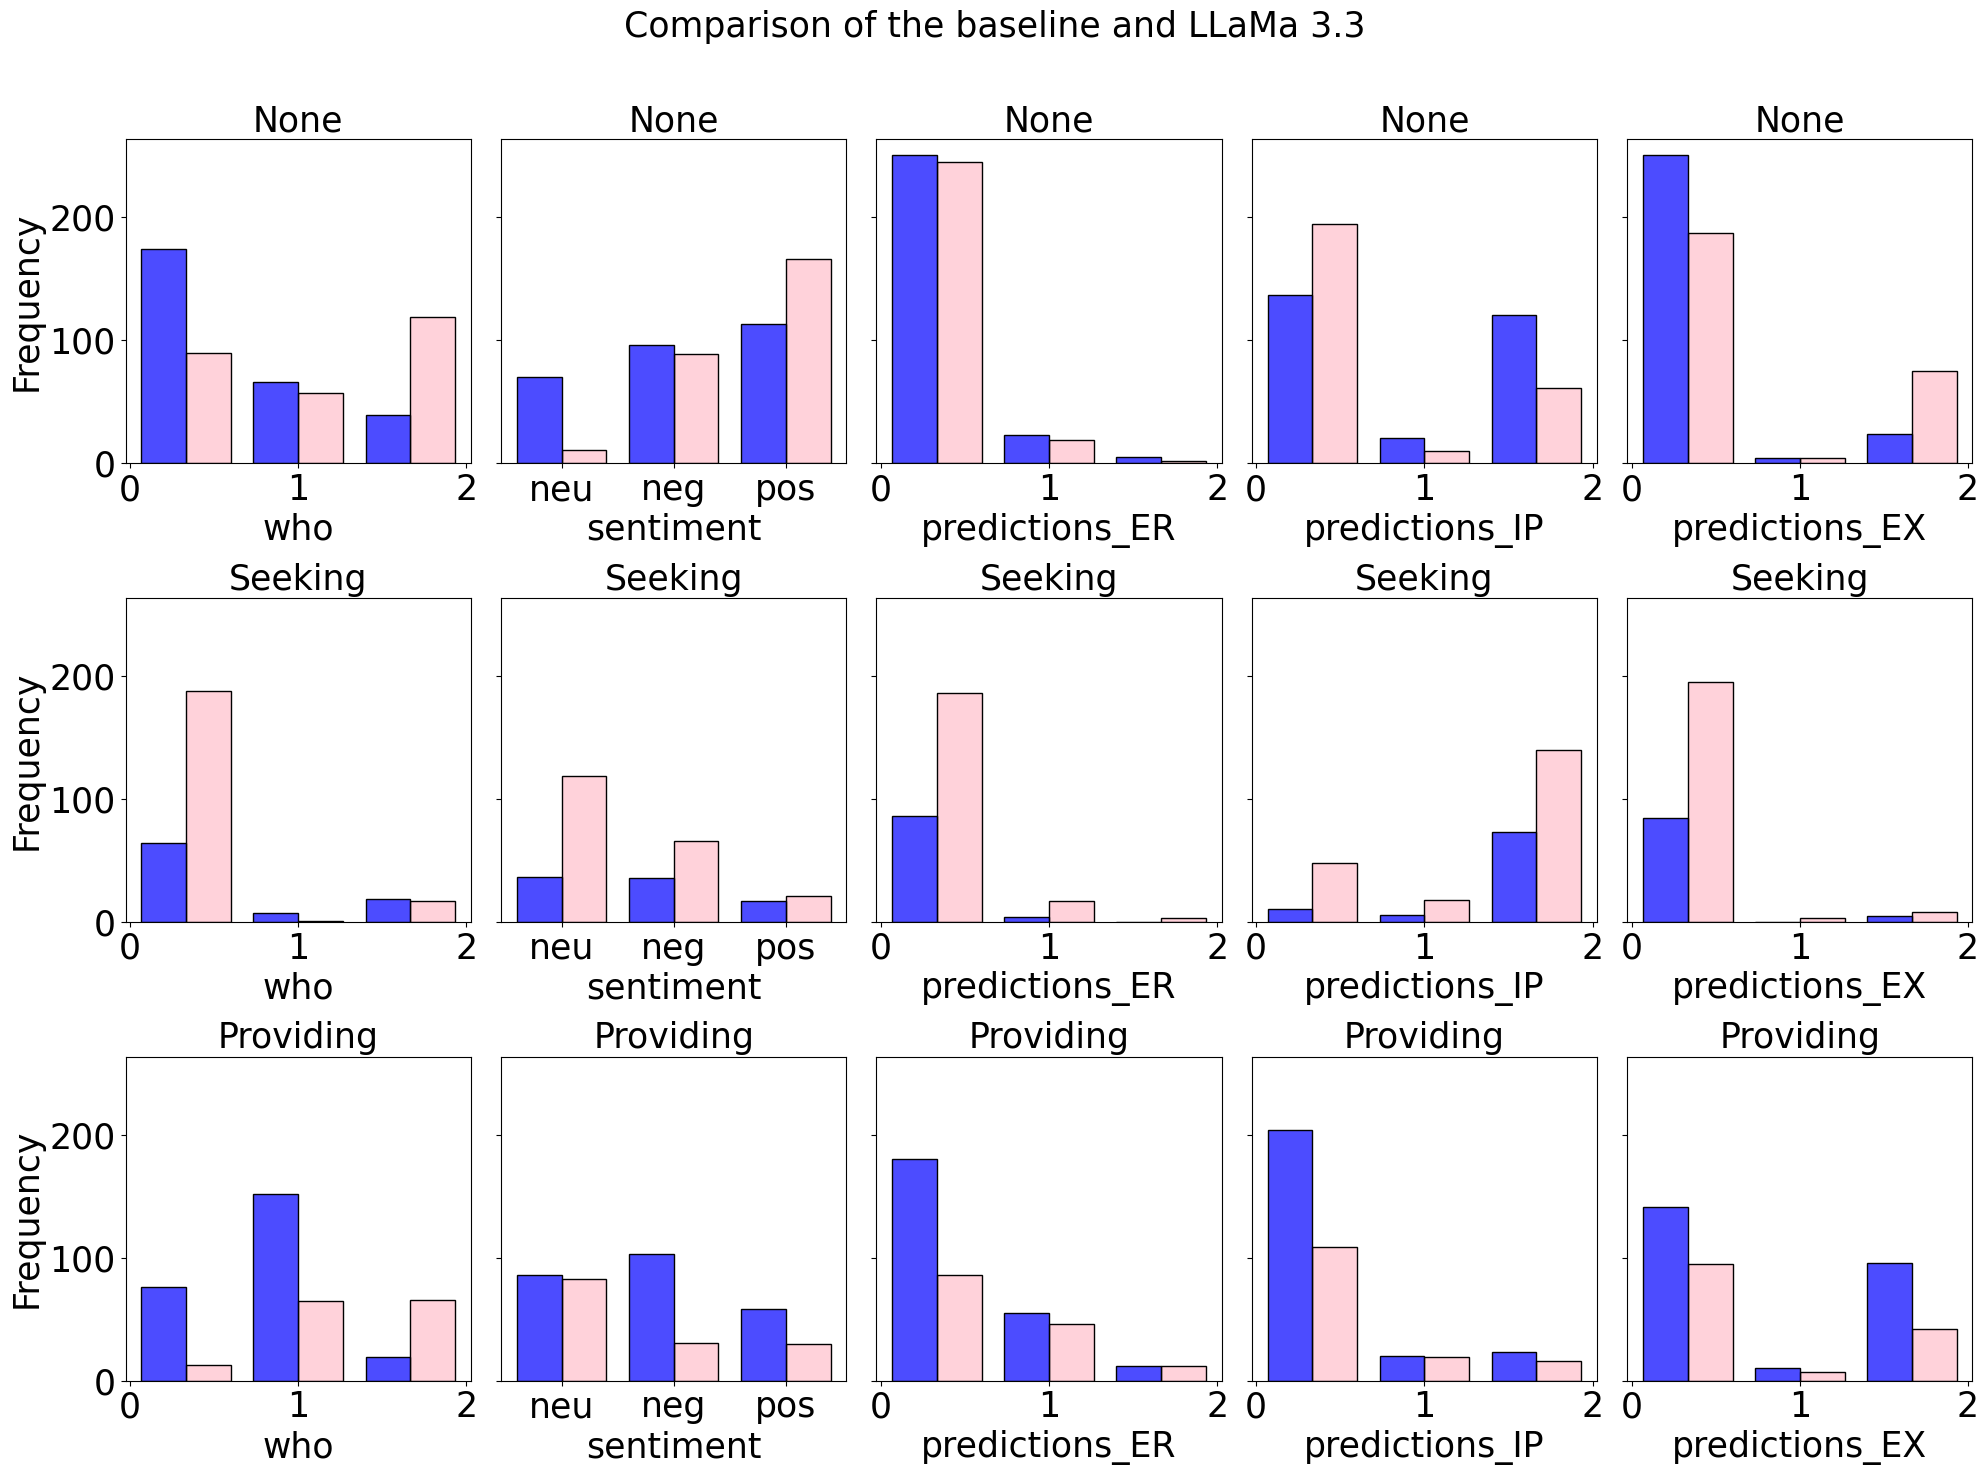

In [79]:
# Relevant columns and their possible values
columns_info = {
    # 'valence': [-1, 1],
    # 'arousal': [-1, 1],
    'who': [0, 1, 2],
    'sentiment': ['neu', 'neg', 'pos'],
    'predictions_ER': [0, 1, 2],
    'predictions_IP': [0, 1, 2],
    'predictions_EX': [0, 1, 2],
}

# Classification labels and their corresponding names
classification_labels = {
    0: 'None',
    1: 'Seeking',
    2: 'Providing'
}

# Set the font size for all text elements
plt.rcParams.update({
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'legend.fontsize': 20,
    'figure.titlesize': 20
})

# Plot for BERT and LLaMa 3.3
fig, axes = plt.subplots(len(classification_labels), len(columns_info), figsize=(20, 15), sharey=True)
fig.suptitle('Comparison of the baseline and LLaMa 3.3', fontsize=25)

bert_dataset = datasets[0]
llama_dataset = datasets[2]

for row, (label, label_name) in enumerate(classification_labels.items()):
    filtered_bert = bert_dataset[bert_dataset['classification_label'] == label].copy()
    filtered_bert['model'] = 'BERT'
    
    filtered_llama = llama_dataset[llama_dataset['classification_label'] == label].copy()
    filtered_llama['model'] = 'LLaMa 3.3'
    
    combined_data = pd.concat([filtered_bert, filtered_llama])
    
    for col, (column, values) in enumerate(columns_info.items()):
        sns.histplot(
            combined_data,
            x=column,
            bins=len(values),
            hue='model',
            multiple='dodge',
            shrink=0.8,
            kde=False,
            ax=axes[row, col],
            palette={'BERT': 'blue', 'LLaMa 3.3': 'pink'},
            alpha=0.7,
            legend=False 
        )
        axes[row, col].set_title(f'{label_name}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_xticks(range(len(values)))
        axes[row, col].set_xticklabels(values)



plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Frequency of Cue Values for HRI

In [111]:
def get_top_3_frequent_values(df, column):
    value_counts = df[column].value_counts()
    total_rows = len(df)
    top_3 = value_counts.nlargest(3)
    proportions = top_3 / total_rows
    return top_3, proportions

In [112]:
# Open a file to save the results
with open('top_3_frequent_values.txt', 'w') as f:
    # Iterate over the datasets and get the top 3 most frequent values

    datasets_2 = [datasets[0], datasets[2]]
    dataset_names = ['BERT', 'LLaMa 3.3']

    for i, dataset in enumerate(datasets_2):
        f.write(f"Dataset: {dataset_names[i]}\n")
        for label, label_name in classification_labels.items():
            filtered_data = dataset[dataset['classification_label'] == label]
            f.write(f"Classification Label: {label_name}\n")
            for column in columns_info.keys():
                top_3_values, percentages = get_top_3_frequent_values(filtered_data, column)
                f.write(f"Top 3 most frequent values for {column}:\n")
                for value, count, percentage in zip(top_3_values.index, top_3_values.values, percentages.values):
                    f.write(f"{value}: {count} ({percentage:.2f})\n")
            f.write("\n")

### Frequency Cues for Non-HRI

In [114]:

# load the data
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'results', 'non_hri_data_test', 'Meta-Llama-3.3-70B-Instruct-AWQ-INT4.csv')
llamma_dataset = pd.read_csv(dataset_path)

# Open a file to save the results
with open('top_3_frequent_non_hri.txt', 'w') as f:
    # Iterate over the datasets and get the top 3 most frequent values

    datasets_3 = [llamma_dataset]
    dataset_names = ['LLaMa 3.3']

    for i, dataset in enumerate(datasets_3):
        f.write(f"Dataset: {dataset_names[i]}\n")
        for label, label_name in classification_labels.items():
            filtered_data = dataset[dataset['classification_label'] == label]
            f.write(f"Classification Label: {label_name}\n")
            for column in columns_info.keys():
                top_3_values, percentages = get_top_3_frequent_values(filtered_data, column)
                f.write(f"Top 3 most frequent values for {column}:\n")
                for value, count, percentage in zip(top_3_values.index, top_3_values.values, percentages.values):
                    f.write(f"{value}: {count} ({percentage:.2f})\n")
            f.write("\n")